In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import functools
from torch.optim import Adam
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from torchvision.datasets import MNIST
import tqdm
import copy

In [ ]:
#@title Defining a time-dependent score-based model

class TimeEncoding(nn.Module):

  def __init__(self, embed_dim, scale=30.):
    super().__init__()
    # Randomly sample weights during initialization. These weights are fixed
    # during optimization and are not trainable.
    self.W = nn.Parameter(torch.randn(embed_dim // 2) * scale, requires_grad=False)
  
  def forward(self, x):
    x_proj = x[:, None] * self.W[None, :] * 2 * np.pi
    return torch.cat([torch.sin(x_proj), torch.cos(x_proj)], dim=-1)

class Dense(nn.Module):
  """A fully connected layer that reshapes outputs to feature maps."""
  def __init__(self, input_dim, output_dim):
    super().__init__()
    self.dense = nn.Linear(input_dim, output_dim)
  
  def forward(self,x):
    return self.dense(x)[..., None, None] # expand two dimensions in the end

class ScoreNet(nn.Module):

  def __init__(self, marginal_prob_std, channels=[32, 64, 128, 256], embed_dim=256):
    """Initial a time-dependent score-based network.
    Args:
    marginal_prob_std: A function that takes time t and gives the standard
     deviation of the perturabtion kernel p_{0t}(x(t) | x(0)).
    channels: The number of channels for feature maps of each solution.
    embed_dim: The dimensionality of Gaussian random feature embeddings.
    """
    super().__init__()
    # Gaussian random feature embedding layer for time
    self.embed = nn.Sequential(TimeEncoding(embed_dim=embed_dim), nn.Linear(embed_dim, embed_dim)) # time embedding

    # Encoder part of U-net
    self.conv1 = nn.Conv2d(1, channels[0], 3, stride=1, bias=False)
    self.dense1 = Dense(embed_dim, channels[0])
    self.gnorm1 = nn.GroupNorm(4, num_channels=channels[0])
    self.conv2 = nn.Conv2d(channels[0], channels[1], 3, stride=2, bias=False)
    self.dense2 = Dense(embed_dim,channels[1])
    self.gnorm2 = nn.GroupNorm(32, num_channels=channels[1])
    self.conv3 = nn.Conv2d(channels[1], channels[2], 3, stride=2, bias=False)
    self.dense3 = Dense(embed_dim, channels[2])
    self.gnorm3 = nn.GroupNorm(32, num_channels=channels[2])
    self.conv4 = nn.Conv2d(channels[2], channels[3], 3, stride=2, bias=False)
    self.dense4 = Dense(embed_dim, channels[3])
    self.gnorm4 = nn.GroupNorm(32, num_channels=channels[3])

    # Decoder part of U-net
    self.tconv4 = nn.ConvTranspose2d(channels[3], channels[2], 3, stride=2, bias=False)
    self.dense5 = Dense(embed_dim, channels[2])
    self.tgnorm4 = nn.GroupNorm(32, num_channels=channels[2])
    self.tconv3 = nn.ConvTranspose2d(channels[2] + channels[2], channels[1], 3, stride=2, bias=False, output_padding=1)
    self.dense6 = Dense(embed_dim, channels[1])
    self.tgnorm3 = nn.GroupNorm(32, num_channels=channels[1])
    self.tconv2 = nn.ConvTranspose2d(channels[1] + channels[1], channels[0], 3, stride=2, bias=False, output_padding=1)
    self.dense7 = Dense(embed_dim, channels[0])
    self.tgnorm2 = nn.GroupNorm(32, num_channels=channels[0])

    # The swish activation f(x) = x*sigmoid(x)
    self.act = lambda x: x * torch.sigmoid(x)

    self.tconv1 = nn.ConvTranspose2d(channels[0] + channels[0], 1, 3, stride=1)
    self.marginal_prob_std = marginal_prob_std
  
  def forward(self, x, t):
    # time embedding
    embed = self.act(self.embed(t))

    # encoder part
    h1 = self.conv1(x)
    h1 += self.dense1(embed)
    h1 = self.gnorm1(h1)
    h1 = self.act(h1)
    h2 = self.conv2(h1)
    h2 += self.dense2(embed)
    h2 = self.gnorm2(h2)
    h2 = self.act(h2)
    h3 = self.conv3(h2)
    h3 += self.dense3(embed)
    h3 = self.gnorm3(h3)
    h3 = self.act(h3)
    h4 = self.conv4(h3)
    h4 += self.dense4(embed)
    h4 = self.gnorm4(h4)
    h4 = self.act(h4)

    # decoder part
    h = self.tconv4(h4)
    h += self.dense5(embed)
    h = self.tgnorm4(h)
    h = self.act(h)
    h = self.tconv3(torch.cat([h,h3], dim=1))
    h += self.dense6(embed)
    h = self.tgnorm3(h)
    h = self.act(h)
    h = self.tconv2(torch.cat([h,h2], dim=1))
    h += self.dense7(embed)
    h = self.tgnorm2(h)
    h = self.act(h)
    h = self.tconv1(torch.cat([h,h1], dim=1))

    # Normalize output
    h = h / self.marginal_prob_std(t)[:, None, None, None] 

    return h

Define the SDE and Denoising Score Matching Objectives

SDE is hand-designed.

First of all, we need to specify an SDE that perturbs the data distribution $p_0$ to a prior distribution $p_T$. We choose the following SDE.

$dx = σ^{t}dw$, $t\in[0,1]$

In this case,

$p_{0t}(x(t)|x(0))=N(x(t),x(0),\frac{1}{2\logσ}(σ^{2t}-1)I)$

and we can choose the weighting function $λ(t)=variance=\frac{1}{2\logσ}(σ^{2t}-1)$.

When $\sigma$ is large, the prior distribution, $p_{t=1}$ is

$\int p_{0}(y)N(x;y,\frac{1}{2\logσ}(σ^{2}-1)I)dy ≈ N(x;0,\frac{1}{2\logσ}(σ^{2}-1)I)$,

which is approximately independent of the data distribution and is easy to sample from.

Intuitively, this SDE captures a continuum of Gaussian perturbations with variance function $\frac{1}{2\logσ}(σ^{2t}-1)$. This continuum of perturbations allows us to gradually transfer samples from a data distribution $p_0$ to a sample Gaussain distribution $p_1$.


In [ ]:
device = 'cuda'

def marginal_prob_std(t, sigma):
  # Calcualte the standard deviation of perturbed Gaussian distribution of time t
  t = torch.tensor(t, device=device)
  return torch.sqrt((sigma**(2*t)-1.)/2./np.log(sigma))

def diffusion_coeff(t, sigma):
  # Calculate the diffusion coefficient of time t
  return torch.tensor(sigma**t, device=device)

sigma = 25.0
marginal_prob_std_fn = functools.partial(marginal_prob_std, sigma=sigma)
diffusion_coeff_fn = functools.partial(diffusion_coeff, sigma=sigma)

In [ ]:
def loss_fn(model, x, marginal_prob_std, eps=1e-5):
  """The loss function for training score-based generative models
  Args:
   model: A PyTorch model instance that represents a time-dependent
    score-based model.
   x: A mini-batch of training data.
   marginal_prob_std: A function that gives the standard deviation of 
    the perturbation kernel
   eps: A tolerance value for numerical stability
  """
  # Step1: Randomly generate float t from [0.00001, 0.9999]
  random_t = torch.rand(x.shape[0], device=x.device) * (1.- eps) + eps

  # Step2: Building a distribution p_t(x) based on reparameter
  z = torch.randn_like(x)
  std = marginal_prob_std(random_t)
  perturbed_x = x + z * std[:, None, None, None]

  # Step3: Predict the score by inputing the noised sample and time into score network
  score = score_model(perturbed_x, random_t)

  # Step4: Caculate the score matching loss
  loss = torch.mean(torch.sum((score * std[:, None, None, None] + z)**2, dim=(1,2,3)))
  return loss

In [ ]:
class EMA(nn.Module):
  def __init__(self, model, decay=0.9999, device = None):
    super(EMA, self).__init__()
    # Make a copy of the model for accumulating moving average of weights
    self.module = copy.deepcopy(model)
    self.module.eval()
    self.dacay = decay
    self.device = device
    if self.device is not None:
      self.module.to(device=device)
    
  
  def _update(self, model, update_fn):
    with torch.no_grad():
      for ema_v, model_v in zip(self.module.state_dict().values(), model.state_dict().values()):
        if self.device is not None:
          model_v = model_v.to(device = self.device)
          ema_v.copy_(update_fn(ema_v, model_v))
  
  def update(self, model):
    self._update(model, update_fn=lambda e, m: self.decay * e + (1. - self.decay) * m)
  
  def set(self, model):
    self._update(model, update_fn=lambda e, m: m)

In [ ]:
#@title Training score-based model on MNIST data

score_model = torch.nn.DataParallel(ScoreNet(marginal_prob_std = marginal_prob_std_fn))
score_model = score_model.to(device)

n_epochs = 50 
## size of a mini-batch
batch_size = 32 
## learning rate
lr = 1e-4 

dataset = MNIST('.', train=True, transform=transforms.ToTensor(), download=True)
data_loader = DataLoader(dataset, batch_size=batch_size, num_workers=4)

optimizer = Adam(score_model.parameters(), lr=lr)
tqdm_epoch = tqdm.tqdm(range(n_epochs))

ema = EMA(score_model)
for epoch in tqdm_epoch:
  avg_loss = 0.
  num_items = 0
  for x, y in data_loader:
    x = x.to(device)
    loss = loss_fn(score_model, x, marginal_prob_std_fn)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    ema.update(score_model)
    avg_loss += loss.item() * x.shape[0]
    num_items += x.shape[0]
  
  print('Average ScoreMatching Loss: {:5f}'.format(avg_loss/num_items))
  torch.save(score_model.state_dict(),'ckpt.pth')

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:566: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
  0%|          | 0/50 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  """
  2%|▏         | 1/50 [00:30<24:32, 30.06s/it]

Average ScoreMatching Loss: 332.266146


  4%|▍         | 2/50 [00:59<23:50, 29.80s/it]

Average ScoreMatching Loss: 67.990469


  6%|▌         | 3/50 [01:28<23:10, 29.58s/it]

Average ScoreMatching Loss: 43.361176


  8%|▊         | 4/50 [01:58<22:38, 29.53s/it]

Average ScoreMatching Loss: 34.229797


 10%|█         | 5/50 [02:31<23:12, 30.94s/it]

Average ScoreMatching Loss: 28.985060


 12%|█▏        | 6/50 [03:06<23:33, 32.12s/it]

Average ScoreMatching Loss: 26.117364


 14%|█▍        | 7/50 [03:38<23:04, 32.20s/it]

Average ScoreMatching Loss: 24.295052


 16%|█▌        | 8/50 [04:12<22:47, 32.57s/it]

Average ScoreMatching Loss: 23.184444


 18%|█▊        | 9/50 [04:48<23:07, 33.84s/it]

Average ScoreMatching Loss: 22.492994


 20%|██        | 10/50 [05:23<22:47, 34.18s/it]

Average ScoreMatching Loss: 22.023980


 22%|██▏       | 11/50 [05:54<21:32, 33.14s/it]

Average ScoreMatching Loss: 21.182223


 24%|██▍       | 12/50 [06:25<20:32, 32.44s/it]

Average ScoreMatching Loss: 20.854390


 26%|██▌       | 13/50 [06:57<20:01, 32.46s/it]

Average ScoreMatching Loss: 20.414589


 28%|██▊       | 14/50 [07:27<19:02, 31.73s/it]

Average ScoreMatching Loss: 20.256302


 30%|███       | 15/50 [07:57<18:14, 31.26s/it]

Average ScoreMatching Loss: 19.939998


 32%|███▏      | 16/50 [08:29<17:43, 31.27s/it]

Average ScoreMatching Loss: 19.537960


 34%|███▍      | 17/50 [09:03<17:39, 32.10s/it]

Average ScoreMatching Loss: 19.737103


 36%|███▌      | 18/50 [09:37<17:25, 32.66s/it]

Average ScoreMatching Loss: 19.333817


 38%|███▊      | 19/50 [10:12<17:20, 33.55s/it]

Average ScoreMatching Loss: 19.256349


 40%|████      | 20/50 [10:46<16:44, 33.48s/it]

Average ScoreMatching Loss: 18.961876


 42%|████▏     | 21/50 [11:23<16:43, 34.60s/it]

Average ScoreMatching Loss: 18.870047


 44%|████▍     | 22/50 [11:59<16:18, 34.94s/it]

Average ScoreMatching Loss: 18.674115


 46%|████▌     | 23/50 [12:33<15:40, 34.83s/it]

Average ScoreMatching Loss: 18.592271


 48%|████▊     | 24/50 [13:08<15:04, 34.79s/it]

Average ScoreMatching Loss: 18.457499


 50%|█████     | 25/50 [13:42<14:21, 34.45s/it]

Average ScoreMatching Loss: 18.394485


 52%|█████▏    | 26/50 [14:18<14:04, 35.18s/it]

Average ScoreMatching Loss: 18.237297


 54%|█████▍    | 27/50 [14:53<13:22, 34.90s/it]

Average ScoreMatching Loss: 18.109726


 56%|█████▌    | 28/50 [15:23<12:18, 33.56s/it]

Average ScoreMatching Loss: 18.045845


 58%|█████▊    | 29/50 [15:53<11:22, 32.52s/it]

Average ScoreMatching Loss: 18.188076


 60%|██████    | 30/50 [16:23<10:33, 31.68s/it]

Average ScoreMatching Loss: 17.834168


 62%|██████▏   | 31/50 [16:52<09:49, 31.04s/it]

Average ScoreMatching Loss: 17.941078


 64%|██████▍   | 32/50 [17:23<09:18, 31.02s/it]

Average ScoreMatching Loss: 17.830016


 66%|██████▌   | 33/50 [17:56<08:53, 31.41s/it]

Average ScoreMatching Loss: 17.782108


 68%|██████▊   | 34/50 [18:31<08:42, 32.64s/it]

Average ScoreMatching Loss: 17.899054


 70%|███████   | 35/50 [19:06<08:19, 33.30s/it]

Average ScoreMatching Loss: 17.560763


 72%|███████▏  | 36/50 [19:39<07:42, 33.06s/it]

Average ScoreMatching Loss: 17.584174


 74%|███████▍  | 37/50 [20:13<07:16, 33.56s/it]

Average ScoreMatching Loss: 17.672966


 76%|███████▌  | 38/50 [20:45<06:37, 33.09s/it]

Average ScoreMatching Loss: 17.450756


 78%|███████▊  | 39/50 [21:16<05:55, 32.36s/it]

Average ScoreMatching Loss: 17.366048


 80%|████████  | 40/50 [21:50<05:29, 32.99s/it]

Average ScoreMatching Loss: 17.426649


 82%|████████▏ | 41/50 [22:23<04:56, 32.92s/it]

Average ScoreMatching Loss: 17.446091


 84%|████████▍ | 42/50 [22:57<04:24, 33.04s/it]

Average ScoreMatching Loss: 17.316653


 86%|████████▌ | 43/50 [23:32<03:56, 33.81s/it]

Average ScoreMatching Loss: 17.207223


 88%|████████▊ | 44/50 [24:05<03:20, 33.42s/it]

Average ScoreMatching Loss: 17.324729


 90%|█████████ | 45/50 [24:38<02:46, 33.39s/it]

Average ScoreMatching Loss: 17.117696


 92%|█████████▏| 46/50 [25:11<02:12, 33.22s/it]

Average ScoreMatching Loss: 17.180634


 94%|█████████▍| 47/50 [25:42<01:38, 32.68s/it]

Average ScoreMatching Loss: 17.004033


 96%|█████████▌| 48/50 [26:12<01:03, 31.95s/it]

Average ScoreMatching Loss: 17.114570


 98%|█████████▊| 49/50 [26:43<00:31, 31.51s/it]

Average ScoreMatching Loss: 17.075222


100%|██████████| 50/50 [27:16<00:00, 32.74s/it]

Average ScoreMatching Loss: 17.145068


In [ ]:
## The number of sampling steps.
num_steps = 500
def euler_sampler(score_model, marginal_prob_std, diffusion_coeff, batch_size=64, num_steps = num_steps, device='cuda', eps=1e-3):
  # Step1: Initialize prior distribution
  t = torch.ones(batch_size, device = device)
  init_x = torch.randn(batch_size, 1, 28, 28, device=device) * marginal_prob_std(t)[:, None, None, None]
  # Step2: Define the sampling t and the time step
  time_steps = torch.linspace(1., eps, num_steps, device=device)
  step_size = time_steps[0] - time_steps[1]

  # Steps3: Calculate SDE
  x = init_x
  with torch.no_grad():
    for time_step in tqdm.tqdm(time_steps):
      batch_time_step = torch.ones(batch_size, device=device) * time_step
      g = diffusion_coeff(batch_time_step)
      mean_x = x + (g**2)[:, None, None, None] * score_model(x, batch_time_step) * step_size
      x = mean_x + torch.sqrt(step_size) * g[:, None, None, None] * torch.randn_like(x)
  
  #Step4: Take the epection of the final step as the sample
  return mean_x

In [ ]:
signal_to_noise_ratio = 0.16
num_steps = 500
def pc_sampler(score_model, marginal_prob_std, diffusion_coeff, batch_size=64, num_steps=num_steps,snr=signal_to_noise_ratio,  device='cuda', eps=1e-3):
  """ Generate samplers from score-based models with Predictor-Corrector method

  Args:
   score_model: A PyTorch model instance that represents a time-dependent
    score-based model.
   marginal_prob_std: A function that gives the standard deviation of 
    the perturbation kernel.
   diffusion_coeff: A function that gives the diffusion coefficient
    of the SDE.
   batch_size: The number of samplers to generate by calling this function 
    once.
   num_steps: The numer of sampling of discretized time steps.
   device: 'cuda' for running on GPUs, and 'cpu' for running on CPUs.
   eps: A tolerance value for numerical stability. 
  
  Returns:
   Samples.
  """
  # Step1: Initialize the prior distribution samples
  t = torch.ones(batch_size, device = device)
  init_x = torch.randn(batch_size, 1, 28, 28, device=device) * marginal_prob_std(t)[:, None, None, None]

  # Step2: Define the sampling t and the time step
  time_steps = torch.linspace(1., eps, num_steps)
  step_size = time_steps[0] - time_steps[1]

  # Step3: Langevin sampling
  x = init_x
  with torch.no_grad():
    for time_step in tqdm.tqdm(time_steps):
      batch_time_step = torch.ones(batch_size, device=device) * time_step

      grad = score_model(x, batch_time_step)
      grad_norm = torch.norm(grad.reshape(grad.shape[0],-1),dim=-1).mean()
      noise_norm = np.sqrt(np.prod(x.shape[1:]))
      langevin_step_size = 2*(snr * noise_norm / grad_norm)**2
     
      for _ in range(20):
        x = x + langevin_step_size * grad + torch.sqrt(2*langevin_step_size) * torch.randn_like(x)
        grad = score_model(x, batch_time_step)
        grad_norm = torch.norm(grad.reshape(grad.shape[0],-1),dim=-1).mean()
        noise_norm = np.sqrt(np.prod(x.shape[1:]))
        langevin_step_size = 2*(snr * noise_norm / grad_norm)**2
      


    # Predict step (Euler-Maruyama)
    g = diffusion_coeff(batch_time_step)
    x_mean = x + (g**2)[:, None, None, None] * score_model(x, batch_time_step) * step_size
    x = x_mean + torch.sqrt(g**2 * step_size)[:, None, None, None] * torch.randn_like(x)
  
  return x_mean

In [ ]:
from scipy import integrate

## The error tolerance for the black-box ODE solver
error_tolerance = 1e-5 
def ode_sampler(score_model, marginal_prob_std, diffusion_coeff, batch_size=64, atol=error_tolerance, rtol=error_tolerance, device='cuda', z=None, eps=1e-3):
  t = torch.ones(batch_size, device=device)
  if z is None:
    init_x = torch.randn(batch_size, 1, 28, 28, device=device) * marginal_prob_std(t)[:, None, None, None]
  else:
    init_x = z
  
  shape = init_x.shape

  # Step2: Define score predicting function
  def score_eval_wrapper(sample, time_steps):
    """A warpper of the score-based model for use by the ODE soler"""
    sample = torch.tensor(sample, device=device, dtype=torch.float32).reshape(shape)
    time_steps = torch.tensor(time_steps, device=device, dtype=torch.float32).reshape((sample.shape[0], ))
    with torch.no_grad():
      score = score_model(sample,time_steps)
    return score.cpu().numpy().reshape((-1,)).astype(np.float64)

  def ode_func(t, x):
    """The ODE function for use by the ODE solver."""
    time_steps = np.ones((shape[0],)) * t
    g = diffusion_coeff(torch.tensor(t)).cpu().numpy()
    return -0.5 * (g**2) * score_eval_wrapper(x, time_steps)
  
  res = integrate.solve_ivp(ode_func, (1., eps), init_x.reshape(-1).cpu().numpy(), rtol=rtol, atol=atol, method='RK45')
  print(f"Number of function evaluations: {res.nfev}")

  x = torch.tensor(res.y[:,-1],device = device).reshape(shape)
  return x
                                                        
                                                  


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  """
100%|██████████| 500/500 [00:47<00:00, 10.54it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  # Remove the CWD from sys.path while we load stuff.


<function pc_sampler at 0x7f3e022f89e0> takes 47.43396878242493s


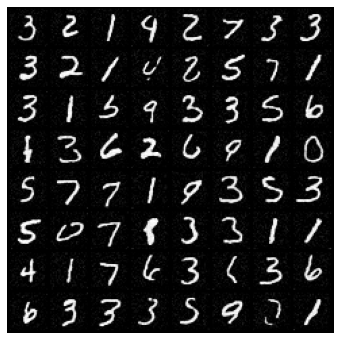

In [ ]:
from torchvision.utils import make_grid
import time

## Load the pre-trained checkpoint from disk.
device = 'cuda'
ckpt = torch.load('ckpt.pth', map_location=device)
score_model.load_state_dict(ckpt)

sample_batch_size = 64
sampler = pc_sampler # One of {'euler_sampler', 'pc_sampler', 'ode_sampler'}

t1 = time.time()
## Generate samples using the specified sampler
samples = sampler(score_model, marginal_prob_std_fn, diffusion_coeff_fn, sample_batch_size, device=device)
t2 = time.time()
print(f'{str(sampler)} takes {t2-t1}s')

## Sample visualization.
samples = samples.clamp(0.0, 1.0)
%matplotlib inline
import matplotlib.pyplot as plt 
sample_grid = make_grid(samples, nrow= int(np.sqrt(sample_batch_size)))
plt.figure(figsize=(6,6))
plt.axis('off')
plt.imshow(sample_grid.permute(1, 2, 0).cpu(), vmin=0., vmax=1.)
plt.show()